### Load libraries

In [93]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error

### Read in DF

In [94]:
all_df = pd.read_msgpack('feature_df___w_mp.mp')

### Subset train df

Only between certain years, not rookie, change in BPM is not null (only if predicting delta)

In [95]:
train_df = all_df[
    (all_df['year'] > 1970) 
    & (all_df['year'] < 2015) 
    & (all_df['years_pro'] > 0) 
    &(all_df['diff'].notnull())
]

### Some LGB params

In [96]:

lgb_params = {
    'boosting_type': 'gbdt',
    'metric': ['rmse'],
    #'num_leaves': 20,
    'learning_rate': 0.05,
    #'feature_fraction': 0.6,
    #'bagging_fraction': 0.6,
    #'bagging_freq': 1,
    #'bagging_freq': 5,
    #'colsample_bytree': .4,
    #'min_data_in_leaf': 2,
    #'reg_alpha': 1,
    #'reg_lambda': 1,
    #'max_depth': 4,
    'verbose': 0
}

### Define X, y, drop any lookahead features

In [97]:
y_diff = train_df['diff']
y = train_df['bpm']
drop_cols =['id', 'ws', 'bpm', 'player_url', 'year', 'mp', 'diff', 'started_team', 'pos']
X = train_df.drop(drop_cols, 1).astype(float)
X_all = all_df.drop(drop_cols, 1).astype(float)

### Define out-of-sample generator

In [98]:
from sklearn.model_selection import KFold
def get_out_of_sample(X, y, weights):
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    all_preds = []
    all_models = []
    for train_index, test_index in kf.split(X):
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        weights_test = weights.iloc[test_index]
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        weights_train = weights.iloc[train_index]
        lgb_data = lgb.Dataset(X_train, y_train, weight=weights_train)
        out = lgb.cv(lgb_params, lgb_data, num_boost_round=10000, nfold=5,
                     early_stopping_rounds=10,stratified=False)
        cv_loss = out['rmse-mean'][-1]
        cv_num_rounds = len(out['rmse-mean'])
        bst = lgb.LGBMRegressor(n_estimators=cv_num_rounds, **lgb_params)
        bst.fit(X_train, y_train, sample_weight=weights_train)
        preds = pd.Series(bst.predict(X_test), index=test_index)
        all_preds.append(preds)
        all_models.append(bst)
    return all_preds, all_models

### When training, care more about players with more minutes

Better actual estimate for their BPM

In [99]:
weights = np.log10(train_df['mp']+1) #* 0 + 1

In [100]:
diff_preds, diff_models = get_out_of_sample(X, y_diff, weights)

In [101]:
full_preds, full_models = get_out_of_sample(X, y, weights)

### Stacking

In [102]:
pred_df = train_df.copy()
diff_pred_series = pd.concat(diff_preds).sort_index()
full_pred_series = pd.concat(full_preds).sort_index()

In [103]:
pred_df['yhat_diff'] = diff_pred_series.values
pred_df['pred_full'] = full_pred_series.values
pred_df['pred_diff'] = pred_df['bpm___1'] + pred_df['yhat_diff']

In [104]:
mean_squared_error(pred_df['bpm'], pred_df['pred_diff'])

8.851663589837068

In [105]:
mean_squared_error(pred_df['bpm'], pred_df['pred_full'])

8.264066757497934

In [106]:
stacked_cols = ['mp___1', 'age', 'pred_full', 'pred_diff', 'mp___2', 'mp___3', 'years_pro', 'yhat_diff', 'bpm___1']

In [107]:
X_stacked = pred_df[stacked_cols]
X_stacked['arb_line'] = (X_stacked['mp___1'] > 200) & (X_stacked['age'] < 30) 

/Users/harrisonchase/workplace/.venvs/record_linking/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [108]:
lgb_data = lgb.Dataset(X_stacked, y, weight=weights)
out = lgb.cv(lgb_params, lgb_data, num_boost_round=10000, nfold=5,
             early_stopping_rounds=10,stratified=False)
cv_loss = out['rmse-mean'][-1]
cv_num_rounds = len(out['rmse-mean'])
cv_loss, cv_num_rounds

(2.2855365158796803, 65)

In [109]:
bst_stacked = lgb.LGBMRegressor(n_estimators=cv_num_rounds, **lgb_params)
bst_stacked.fit(X_stacked, y, sample_weight=weights)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              metric=['rmse'], min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=65, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0, verbose=0)

### Predict and transform back to BPM prediction

In [110]:
all_full_preds = []
for bst in full_models:
    all_full_preds.append(bst.predict(X_all))

In [111]:
all_diff_preds = []
for bst in diff_models:
    all_diff_preds.append(bst.predict(X_all))

In [112]:
all_full_pred_series = pd.DataFrame(all_full_preds).T.mean(axis=1)

In [113]:
all_diff_pred_series = pd.DataFrame(all_diff_preds).T.mean(axis=1)

In [114]:
all_pred_df = all_df.copy()
all_pred_df['pred_full'] = all_full_pred_series.values
all_pred_df['yhat_diff'] = all_diff_pred_series.values
all_pred_df['pred_diff'] = all_pred_df['yhat_diff'] + all_pred_df['bpm___1']

In [115]:
X_stacked_all = all_pred_df[stacked_cols]
X_stacked_all['arb_line'] = (X_stacked_all['mp___1'] > 200) & (X_stacked_all['age'] < 30) 

/Users/harrisonchase/workplace/.venvs/record_linking/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [116]:
preds = bst_stacked.predict(X_stacked_all)

In [117]:
all_pred_df['pred'] = preds

### Look at predictions for recent year

In [118]:
recent = all_pred_df[(all_pred_df['year'] >= 2015) & (all_pred_df['year'] < 2020)].sort_values('pred')
#recent = all_pred_df[(all_pred_df['year'] == 2020)].sort_values('pred', ascending=False)
recent = recent[(recent['years_pro'] > 0)]

In [119]:
recent

,player_url,year,ws,id,bpm,mp,age,pick_overall,C,F,...,team_mp___1_new,team_mp___1_returning,pos_team_mp___1,pos_team_mp___1_new,pos_team_mp___1_returning,last_year_mvp,pred_full,yhat_diff,pred_diff,pred
17911,/players/t/thomala01.html,2015,-0.4,/players/t/thomala01.html___2015,-5.7,1490.0,26,NaN,0,0,...,2474.0,15935.0,4061.0,42.0,4019.0,False,-5.669960,3.391951,-7.308049,-7.714706
14936,/players/c/cabocbr01.html,2017,0.1,/players/c/cabocbr01.html___2017,0.8,40.0,21,20.0,0,0,...,1915.0,15033.0,2576.0,NaN,2576.0,False,-7.329344,3.654089,-7.945911,-7.106190
16145,/players/r/robinde01.html,2019,0.3,/players/r/robinde01.html___2019,1.0,95.0,23,NaN,0,0,...,6500.0,14104.0,4676.0,0.0,4676.0,False,-4.732322,5.646821,-2.553179,-6.872160
14314,/players/m/mekelga01.html,2015,-0.2,/players/m/mekelga01.html___2015,-16.6,43.0,26,NaN,0,0,...,2895.0,12551.0,3293.0,292.0,2482.0,False,-5.388545,3.637623,-5.562377,-6.782529
15635,/players/n/niangge01.html,2018,0.0,/players/n/niangge01.html___2018,-4.0,32.0,24,50.0,0,0,...,5390.0,11565.0,1325.0,1325.0,NaN,False,-6.320199,5.263708,-6.736292,-6.382209
14780,/players/r/randlju01.html,2016,1.6,/players/r/randlju01.html___2016,-3.6,2286.0,21,7.0,0,0,...,5871.0,6063.0,3176.0,1929.0,1247.0,False,-5.518122,12.908959,-3.891041,-6.106995
14189,/players/g/gordobe01.html,2015,0.3,/players/g/gordobe01.html___2015,-6.1,790.0,31,3.0,0,0,...,4963.0,10461.0,5138.0,2651.0,2487.0,False,-6.441554,0.581479,-6.218521,-6.095810
14521,/players/c/cabocbr01.html,2016,-0.3,/players/c/cabocbr01.html___2016,-11.6,43.0,20,20.0,0,0,...,7429.0,12274.0,4304.0,2189.0,2115.0,False,-6.213293,13.696986,-5.203014,-5.972289
14749,/players/o/obryajo01.html,2016,0.3,/players/o/obryajo01.html___2016,-6.0,857.0,22,36.0,0,0,...,4956.0,10667.0,1934.0,828.0,1106.0,False,-4.712003,2.874438,-6.125562,-5.892861
14548,/players/c/curryse01.html,2016,1.4,/players/c/curryse01.html___2016,-1.5,692.0,25,NaN,0,0,...,5654.0,10074.0,3591.0,8.0,1565.0,False,-4.888594,12.092704,-3.807296,-5.816092


In [120]:
missing = recent[recent['bpm___1'].isnull()]
regular = recent[recent['bpm___1'].notnull()]

In [88]:
mean_squared_error(missing['bpm'], missing['pred_full'])

69.32569064474112

In [89]:
mean_squared_error(missing['bpm'], missing['pred'])

69.44355573394118

In [90]:
mean_squared_error(regular['bpm'], regular['pred_full'])

8.130544547118905

In [91]:
mean_squared_error(regular['bpm'], regular['pred_diff'])

10.159374238962835

In [92]:
mean_squared_error(regular['bpm'], regular['pred'])

8.066590958060086

### Look into data!!

In [212]:
recent1 = recent.copy()

In [213]:
from sklearn.metrics import mean_squared_error

In [222]:
merged = recent1[['id', 'bpm___1', 'mp___1', 'age', 'pred', 'bpm', 'pred_diff', 'pred_full']].merge(recent[['id', 'pred']], how='left', on='id')

In [223]:
merged_non_null = merged.dropna(subset=['pred_x', 'pred_y'])

In [224]:
mask = (merged_non_null['mp___1'] > 200) & (merged_non_null['age'] == 25) #& ((merged_non_null['age'] > 20))

In [225]:
x = merged_non_null[mask]
y = merged_non_null[~mask]

In [226]:
mean_squared_error(x['bpm'], x['pred_diff'])

5.099579375797721

In [227]:
mean_squared_error(x['bpm'], x['pred_full'])

5.033571111371002

In [220]:
mean_squared_error(y['bpm'], y['pred_x'])

10.73930836556481

In [221]:
mean_squared_error(y['bpm'], y['pred_y'])

10.73930836556481

In [233]:
zs = []
for age in range(20, 38):
    mask = (merged_non_null['mp___1'] > 300) & (merged_non_null['age'] == age) #& ((merged_non_null['age'] > 20))
    x = merged_non_null[mask]
    y = merged_non_null[~mask]
    z = mean_squared_error(x['bpm'], x['pred_x']) - mean_squared_error(x['bpm'], x['pred_y'])
    zs.append(z)

In [234]:
%matplotlib inline

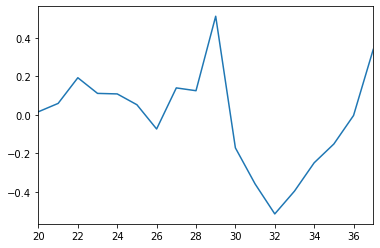

In [235]:
pd.Series(zs, index=range(20,38)).plot()

In [321]:
def max_bpm(row):
    return row[['bpm___1', 'bpm___2', 'bpm___3']].max()

In [322]:
recent['delta'] = recent['pred'] - recent.apply(max_bpm, axis=1)* 1

In [326]:
recent.sort_values('delta', ascending=False)[lambda x: x['pred'] > 0]

,player_url,year,ws,id,bpm,mp,age,pick_overall,C,F,...,team_mp___1_new,team_mp___1_returning,pos_team_mp___1,pos_team_mp___1_new,pos_team_mp___1_returning,pred_full,yhat_diff,pred_diff,pred,delta
18229,/players/c/cartewe01.html,2020,NaN,/players/c/cartewe01.html___2020,NaN,NaN,20,7.0,1,0,...,5437.0,11384.0,1856.0,NaN,1856.0,0.310087,1.128618,0.628618,0.503351,1.003351
18183,/players/a/aytonde01.html,2020,NaN,/players/a/aytonde01.html___2020,NaN,NaN,21,1.0,1,0,...,4948.0,7800.0,3759.0,1576.0,2183.0,1.055146,0.814416,1.014416,1.003855,0.803855
18187,/players/b/bambamo01.html,2020,NaN,/players/b/bambamo01.html___2020,NaN,NaN,21,6.0,1,0,...,2719.0,16865.0,3919.0,NaN,3919.0,0.060762,0.379120,0.179120,0.360693,0.560693
18332,/players/j/jacksja02.html,2020,NaN,/players/j/jacksja02.html___2020,NaN,NaN,20,4.0,0,0,...,9973.0,4821.0,2236.0,NaN,2236.0,0.405998,0.469793,0.569793,0.539390,0.439390
18265,/players/e/embiijo01.html,2020,NaN,/players/e/embiijo01.html___2020,NaN,NaN,25,3.0,1,0,...,5357.0,6551.0,4498.0,2344.0,2154.0,3.805939,0.097745,4.197745,4.448470,0.348470
18398,/players/m/murraja01.html,2020,NaN,/players/m/murraja01.html___2020,NaN,NaN,22,7.0,0,0,...,2663.0,18184.0,4417.0,NaN,4417.0,-0.108451,0.323596,0.423596,0.276429,0.176429
18174,/players/a/allenja01.html,2020,NaN,/players/a/allenja01.html___2020,NaN,NaN,21,22.0,1,0,...,7646.0,8910.0,4143.0,NaN,2096.0,2.744968,0.126882,2.626882,2.660674,0.160674
18209,/players/b/bookede01.html,2020,NaN,/players/b/bookede01.html___2020,NaN,NaN,23,13.0,0,0,...,4948.0,7800.0,2242.0,NaN,2242.0,0.772131,0.269231,1.069231,0.923445,0.123445
18257,/players/d/doncilu01.html,2020,NaN,/players/d/doncilu01.html___2020,NaN,NaN,20,3.0,0,0,...,1399.0,10263.0,6655.0,1399.0,2771.0,3.328074,0.255333,4.355333,4.210251,0.110251
18489,/players/w/whitede01.html,2020,NaN,/players/w/whitede01.html___2020,NaN,NaN,25,29.0,0,0,...,2823.0,16610.0,3636.0,NaN,3636.0,0.980297,0.208835,1.108835,0.986180,0.086180
